In [3]:
### Import the necessary libraries and packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
%matplotlib inline


In [ ]:
# Define a function to extract the target objects from the larger Udacity image and store them to a folder
def extract_images(data, filepath):
    for ii, img in enumerate(data):
         # Read in each one by one
        file = img[0]
        image = mpimg.imread(file)
        # Isolate the region in the image that contains the object
        xmin, ymin, xmax, ymax = img[1], img[2], img[3], img[4]
        image = image[ymin:ymax + 1, xmin:xmax + 1]
        image = cv2.resize(image, (64, 64))
        filler = '00000'
        mpimg.imsave(filepath + 'image_' + filler[:len(filler) - len(str(ii))] + str(ii) + '.jpg', image)
        

In [45]:
# Collect the filenames for all car images in the dataset
car_gti_far = glob.glob('../data/vehicles/GTI_Far/*png')
car_gti_left = glob.glob('../data/vehicles/GTI_Left/*png')
car_gti_midclose = glob.glob('../data/vehicles/GTI_MiddleClose/*png')
car_gti_right = glob.glob('../data/vehicles/GTI_Right/*png')
kitti_cars = glob.glob('../data/vehicles/KITTI_extracted/*png')

# Collect the filenames for all non-car images in the dataset
non_car_gti = glob.glob('../data/non_vehicles/GTI/*png')
extras_non_cars = glob.glob('../data/non_vehicles/Extras/*png')

car_files = np.array(car_gti_far + car_gti_left + car_gti_midclose + car_gti_right + kitti_cars)
non_car_files = np.array(non_car_gti + extras_non_cars)

print('Number of car files: {}'.format(len(car_files)))
print('Number of non car files: {}'.format(len(non_car_files)))

all_img_files = np.hstack((non_car_files, car_files))
img_type_labels = np.hstack((np.zeros(len(non_car_files)), np.ones(len(car_gti_far)), np.ones(len(car_gti_left)) * 2, 
                                 np.ones(len(car_gti_midclose)) * 3, np.ones(len(car_gti_right)) * 4, 
                                 np.ones(len(kitti_cars)) * 5))

print('Total number of images: {}'.format(all_img_files.shape))
print('Total number of labels: {}'.format(img_type_labels.shape))


Number of car files: 8792
Number of non car files: 8968
Total number of images: (17760,)
Total number of labels: (17760,)


In [74]:
def convert_color(img, conv=None):
    image = np.copy(img)
    if conv:
        transform = "cv2.cvtColor(image, cv2.COLOR_" + conv + ")"
        features = eval(transform)
    else:
        features = image
    
    return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', 
                                  transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

In [48]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(data, img_format, spatial=False, hist=False, spatial_size=64, hist_bins=64, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=None):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in data:
        single_img_features = []
        # Read in each one by one
        image = mpimg.imread(file) 
        # apply color conversion
        image_conv1 = convert_color(image, 'RGB2HLS')
            
        if spatial:
            spatial_features = bin_spatial(image_conv[0], size=(spatial_size, spatial_size))
            single_img_features.append(spatial_features)
        if hist:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 256))
            single_img_features.append(hist_features)
        if hog_channel is not None:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            single_img_features.append(hog_features)
            
        features.append(np.concatenate(single_img_features))
        
    # Return list of feature vectors
    return features


In [49]:
import pickle

# Save a dictionary into a pickle file
def save_to_pickle(data, key_name, file_name):
    if len(file_name) > 1:
        for d, k, f in zip(data, key_name, file_name):
            pickle_data = {k: d}
            pickle.dump(pickle_data, open(f + '.p', "wb"))
    else:
        pickle_data = {}
        for d, k in zip(data, key_name):
            pickle_data[k] = d
        print(pickle_data)
        pickle.dump(pickle_data, open(file_name[0] + '.p', "wb"))
        

In [50]:
# Shuffle the image files based on the assigned labels
X_train, y_train = shuffle(all_img_files, img_type_labels, random_state=42)
print(len(X_train), len(y_train))
print(X_train[:20])
print(y_train[:20])


17760 17760
['../data/vehicles/KITTI_extracted/image_03521.png'
 '../data/vehicles/GTI_Right/image0881.png'
 '../data/vehicles/GTI_Left/image0628.png'
 '../data/non_vehicles/Extras/extra3575.png'
 '../data/non_vehicles/Extras/extra2435.png'
 '../data/non_vehicles/GTI/image1581.png'
 '../data/non_vehicles/Extras/extra1978.png'
 '../data/vehicles/KITTI_extracted/image_00691.png'
 '../data/vehicles/KITTI_extracted/image_01195.png'
 '../data/vehicles/KITTI_extracted/image_03749.png'
 '../data/vehicles/GTI_Right/image0224.png'
 '../data/vehicles/KITTI_extracted/image_03662.png'
 '../data/vehicles/KITTI_extracted/image_05849.png'
 '../data/non_vehicles/GTI/image1057.png'
 '../data/vehicles/KITTI_extracted/image_00055.png'
 '../data/non_vehicles/Extras/extra2508.png'
 '../data/non_vehicles/Extras/extra1671.png'
 '../data/non_vehicles/Extras/extra15.png'
 '../data/vehicles/KITTI_extracted/image_04204.png'
 '../data/vehicles/GTI_Left/image0411.png']
[ 5.  4.  2.  0.  0.  0.  0.  5.  5.  5.  4. 

In [55]:
from collections import Counter

num_labels = Counter(y_train)
num_imgs = len(all_img_files)
print(num_labels.most_common())
print('{}: {:.0f}, {}: {:.0f}, {}: {:.0f}, {}: {:.0f}, {}: {:.0f}, {}: {:.0f}'.format(
                                                    0.0, len(non_car_files) * len(y_train) / num_imgs,
                                                    5.0, len(kitti_cars) * len(y_train) / num_imgs,
                                                    2.0, len(car_gti_left) * len(y_train) / num_imgs,
                                                    1.0, len(car_gti_far) * len(y_train) / num_imgs,
                                                    4.0, len(car_gti_right) * len(y_train) / num_imgs,
                                                    3.0, len(car_gti_midclose) * len(y_train) / num_imgs)
                                                                         )
# Convert the different car labels to 1
y_train_copy = np.copy(y_train)
y_train_copy[y_train_copy != 0] = 1.
print(y_train)
print(y_train_copy)
print(type(y_train_copy))

[(0.0, 8968), (5.0, 5966), (2.0, 909), (1.0, 834), (4.0, 664), (3.0, 419)]
0.0: 8968, 5.0: 5966, 2.0: 909, 1.0: 834, 4.0: 664, 3.0: 419
[ 5.  4.  2. ...,  0.  0.  5.]
[ 1.  1.  1. ...,  0.  0.  1.]
<class 'numpy.ndarray'>


In [56]:
spatial_size = 32
histbin = 32
cspace = 'RGB2YCrCb'
spatial = True
hist = True
hog_channel = 'ALL'
img_format = 'png'
## Here is a list of possible color spaces to use
'''cv2.COLOR_RGB2HSV
   cv2.COLOR_RGB2LUV
   cv2.COLOR_RGB2HLS
   cv2.COLOR_RGB2YUV
   cv2.COLOR_RGB2YCrCb'''

X_train_features = extract_features(X_train, img_format=img_format, cspace=cspace, spatial=spatial, 
                                    hist=hist, spatial_size=spatial_size, hist_bins=histbin, orient=9, pix_per_cell=8, 
                                    cell_per_block=2, hog_channel=hog_channel)


In [57]:
X_train_features = np.array(X_train_features).astype(np.float32)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train_features)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_train_features)
print('X train features shape is {}'.format(X_train_features.shape))
print('Scaled X features is {}'.format(scaled_X.shape))

X train features shape is (17760, 8460)
Scaled X features is (17760, 8460)


In [58]:
# Shuffle and split the data into a training and test set
X_train, X_validate, y_train, y_validate = train_test_split(scaled_X, y_train_copy, test_size=0.2, 
                                                    stratify=y_train_copy, random_state=42)
print('X_train shape is {}'.format(X_train.shape))
print('y_train shape is {}'.format(y_train.shape))
print('X_validate shape is {}'.format(X_validate.shape))
print('y_validate shape is {}'.format(y_validate.shape))

X_train shape is (14208, 8460)
y_train shape is (14208,)
X_validate shape is (3552, 8460)
y_validate shape is (3552,)


In [59]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


29.57 Seconds to train SVC...


In [60]:
print('Test Accuracy of SVC = ', round(svc.score(X_validate, y_validate), 4))

Test Accuracy of SVC =  0.9789


In [61]:
save_to_pickle([svc, X_scaler], ['svc', 'scaler'], ['svc_pickle'])

{'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [38]:
### I can start from here after I've saved the features to pickle file, instead of at the beginning
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
import pickle
%matplotlib inline

def convert_color(img, conv=None):
    image = np.copy(img)
    if conv:
        transform = "cv2.cvtColor(image, cv2.COLOR_" + conv + ")"
        features = eval(transform)
    else:
        features = image
    
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    # Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(data, img_format, cspace='RGB2YCrCb', spatial=False, hist=False, spatial_size=64, hist_bins=64, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=None):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in data:
        single_img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
#         if img_format == 'png':
#             image *= 255
#             image = image.astype(np.uint8)
            
        # apply color conversion
        feature_image = convert_color(image, cspace)
        print('extract features max: {}'.format(np.max(feature_image)))
        if hog_channel is not None:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            single_img_features.append(hog_features)
            
        if spatial:
            spatial_features = bin_spatial(feature_image, size=(spatial_size, spatial_size))
            single_img_features.append(spatial_features)
        if hist:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 256))
            single_img_features.append(hist_features)
            
        features.append(np.concatenate(single_img_features))
        
    # Return list of feature vectors
    return features




In [62]:
## Bring in images from another dataset and test the classifier on those images
spatial_size = 32
hist_bins = 32
cspace = 'RGB2YCrCb'
spatial = True
hist = True
hog_channel = 'ALL'
img_format = 'png'

dict_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dict_pickle["svc"]
X_scaler = dict_pickle["scaler"]

In [65]:
# Define a single function that can extract features using hog sub-sampling 
# and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial, hist, spatial_size, hist_bins, cspace):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=cspace)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), 
                                     np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, 
                            feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, 
                            feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, 
                            feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, 
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
           # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, 
                                xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = np.array([])
            hist_features = np.array([])
            if spatial:
                spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            if hist:
                hist_features = color_hist(subimg, nbins=hist_bins, bins_range=(0, 256))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, 
                                                          hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


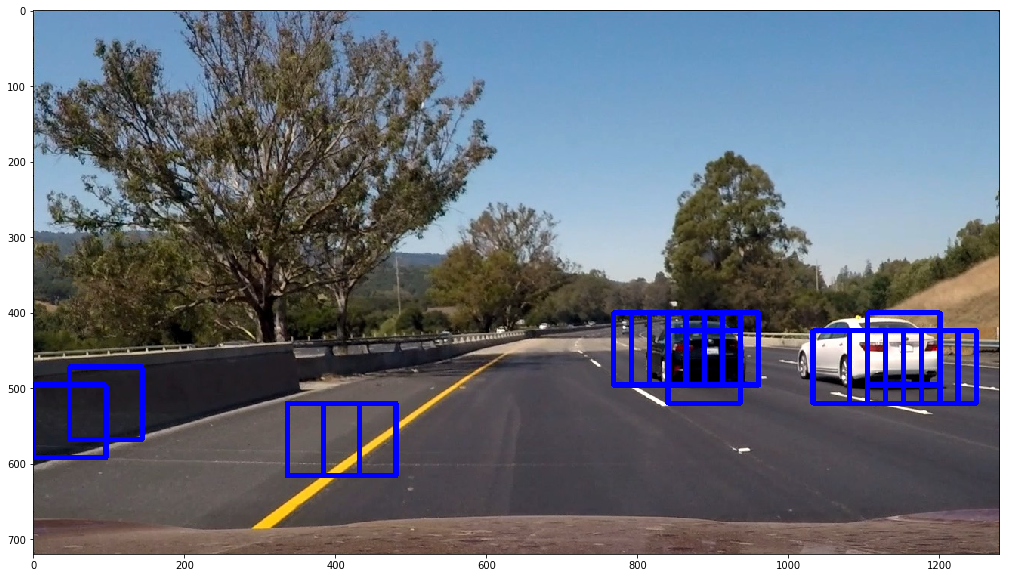

In [73]:
ystart = 400
ystop = 656
scale = 1.5
orient=9
pix_per_cell=8
cell_per_block=2
img = mpimg.imread('../test_images/test6.jpg')
# fig = plt.figure(figsize=(20, 10))
# plt.imshow(img)

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hist, 
                    spatial_size, hist_bins, cspace)

fig = plt.figure(figsize=(20, 10))
plt.imshow(out_img)